In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

### Process the images and resize them to the preferred size

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### Preparing the training and testing data

In [ ]:
train = get_training_data('/content/drive/MyDrive/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [ ]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1369
Pneumonia - Normal: 2506


### Visualize training images

PNEUMONIA


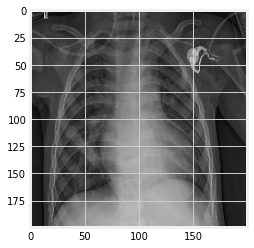

In [ ]:
plt.imshow(train[1][0], cmap='gray')
print(labels[train[1][1]])

### Incoprating the validation data into the training data

In [ ]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
X_train

array([[[[0.10588235],
         [0.11372549],
         [0.11372549],
         ...,
         [0.01176471],
         [0.04313725],
         [0.0627451 ]],

        [[0.10588235],
         [0.12156863],
         [0.09803922],
         ...,
         [0.03921569],
         [0.03921569],
         [0.02352941]],

        [[0.10588235],
         [0.10196078],
         [0.11764706],
         ...,
         [0.02745098],
         [0.01568627],
         [0.02745098]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.04705882],
         [0.0745098 ],
         [0.09

In [ ]:
X_test

array([[[[0.17254902],
         [0.10196078],
         [0.04313725],
         ...,
         [0.02352941],
         [0.04313725],
         [0.05490196]],

        [[0.24705882],
         [0.21176471],
         [0.03921569],
         ...,
         [0.01568627],
         [0.04705882],
         [0.        ]],

        [[0.04705882],
         [0.16470588],
         [0.05490196],
         ...,
         [0.00392157],
         [0.00784314],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.41568627],
         [0.41568627],
         [0.4 

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss')
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 256)     2560      
                                                                 
 activation_5 (Activation)   (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 256)    0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 100, 100, 256)    400       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_6 (Activation)   (None, 100, 100, 64)     

In [ ]:
history = model.fit(X_train, y_train, batch_size=15, epochs=10, validation_split=0.20, callbacks=[early_stop])

Epoch 1/10
251/251 [==============================] - 1553s 6s/step - loss: 0.4658 - acc: 0.7867 - val_loss: 1.7246 - val_acc: 0.6953
Epoch 2/10
251/251 [==============================] - 1577s 6s/step - loss: 0.2518 - acc: 0.9041 - val_loss: 0.5132 - val_acc: 0.7113
Epoch 3/10
251/251 [==============================] - 1576s 6s/step - loss: 0.1888 - acc: 0.9286 - val_loss: 0.1430 - val_acc: 0.9459
Epoch 4/10
251/251 [==============================] - 1575s 6s/step - loss: 0.1713 - acc: 0.9355 - val_loss: 0.1396 - val_acc: 0.9522
Epoch 5/10
251/251 [==============================] - 1623s 6s/step - loss: 0.1525 - acc: 0.9424 - val_loss: 0.1352 - val_acc: 0.9512
Epoch 6/10
251/251 [==============================] - 1581s 6s/step - loss: 0.1398 - acc: 0.9474 - val_loss: 0.1345 - val_acc: 0.9490
Epoch 7/10
251/251 [==============================] - 1578s 6s/step - loss: 0.1443 - acc: 0.9471 - val_loss: 0.1358 - val_acc: 0.9575
Epoch 8/10
251/251 [==============================] - 1578s 6s

In [ ]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 129s 3s/step - loss: 0.6912 - acc: 0.6347


[0.6912070512771606, 0.6346644163131714]

### Visualizing our training progress

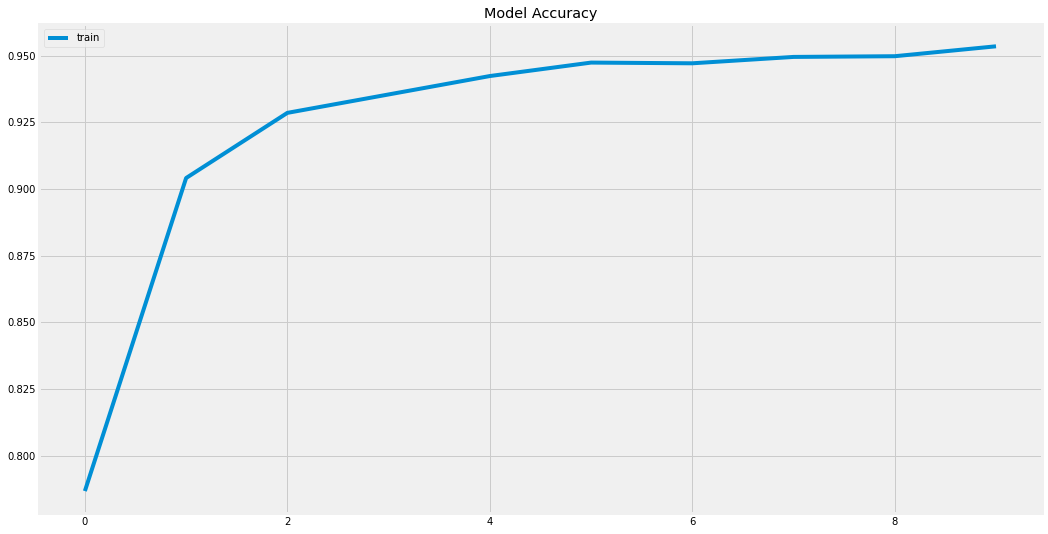

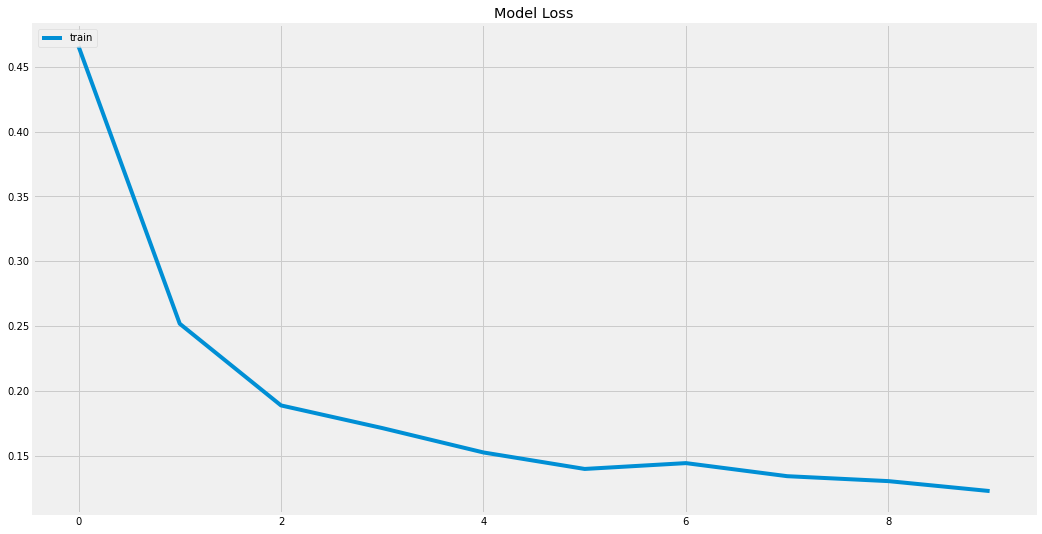

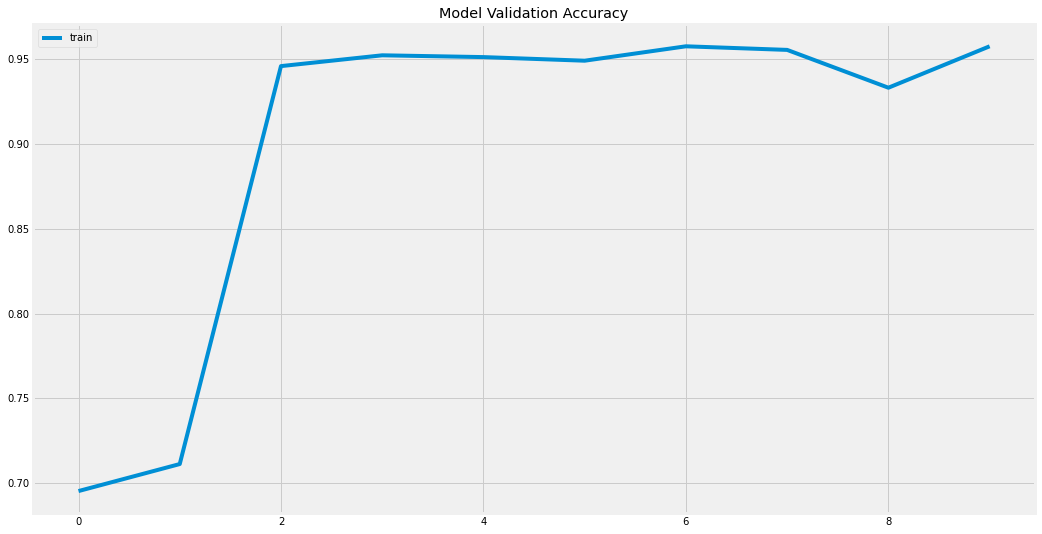

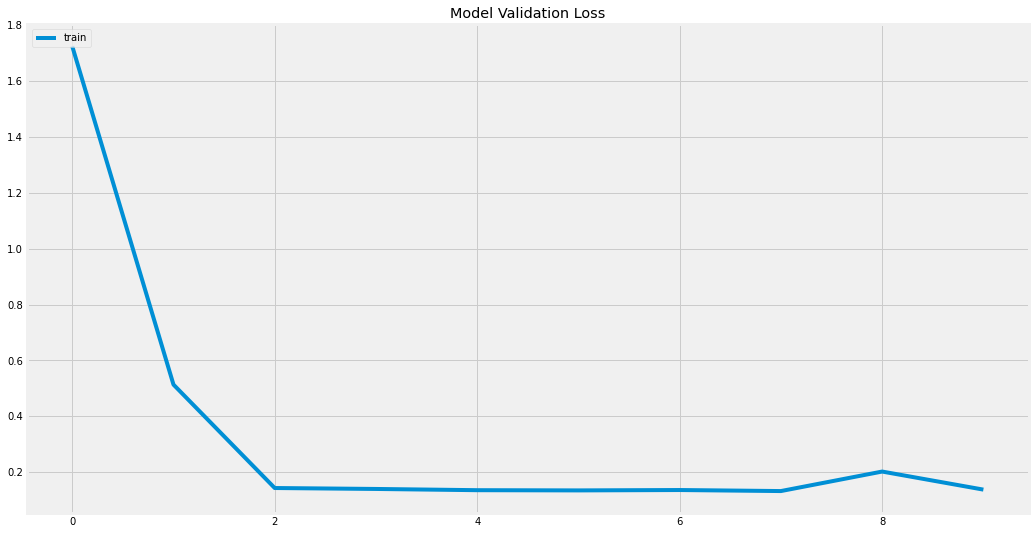

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

### Prepare data for precision vs. recall and ROC

In [ ]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

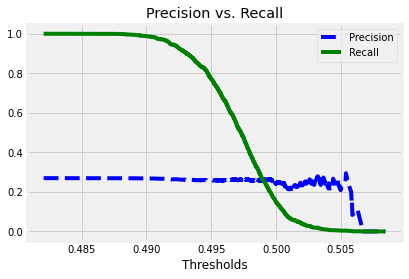

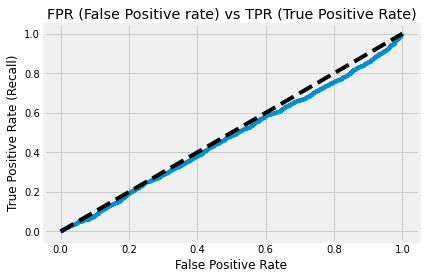

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [ ]:
predictions = model.predict(X_test)

### Set thresholds for our model, we want the results to be precise while not sacraficing too much recall

In [ ]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.25)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.2905692438402719
Precision on testing set: 1.0
Recall on testing set: 0.2905692438402719


###Plotting the confusion matrix

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

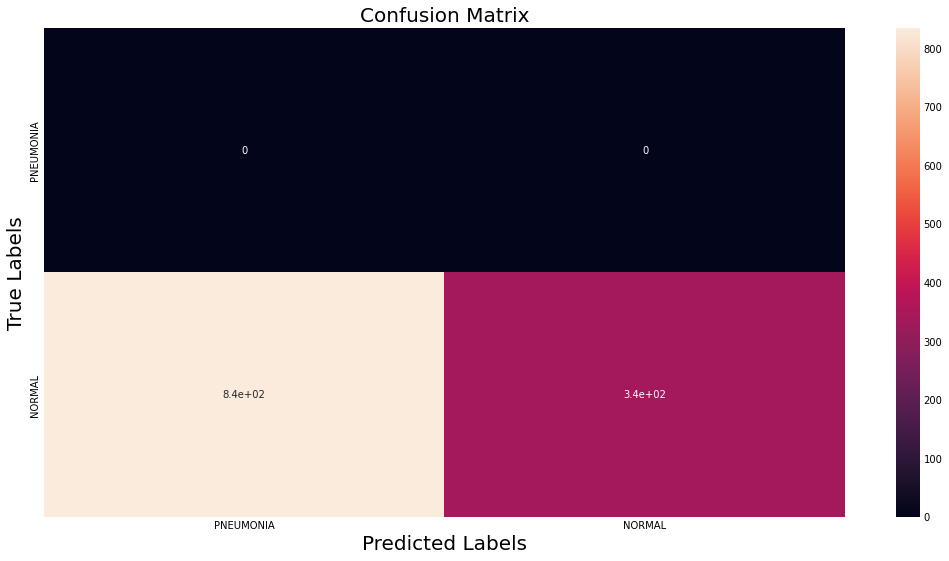

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

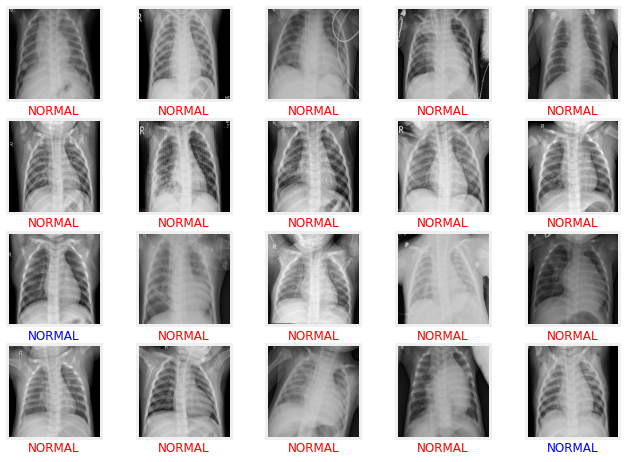

In [ ]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

### Download the model

In [ ]:
 model.save('pneumonia_detection_ai_version_2.h5')